In [1]:
import cv2
import einops
import matplotlib.pyplot as plt
import numpy as np

import brutesac
import utils

In [2]:
def get_board_patches(src_image):
    src_gray = cv2.cvtColor(src_image, cv2.COLOR_RGB2GRAY)
    xpts = utils.classify_image(frame=src_gray)
    (
        raw_M,
        best_quad,
        best_offset,
        best_score,
        best_error_score,
    ) = brutesac.brutesac_chessboard(xpts)
    M_homog = brutesac.refine_homography(xpts, raw_M, best_offset)

    ideal_grid_pts = np.vstack(
        [np.array([0, 0, 1, 1, 0]) * 8 - 1, np.array([0, 1, 1, 0, 0]) * 8 - 1]
    ).T

    # Refined via homography of all valid points
    unwarped_ideal_chess_corners_homography = cv2.perspectiveTransform(
        np.expand_dims(ideal_grid_pts.astype(float), 0), np.linalg.inv(M_homog)
    )[0, :, :]

    a, b, c, d = unwarped_ideal_chess_corners_homography[:-1]
    candidates = [(a, b, c, d), (b, c, d, a), (c, d, a, b), (d, a, b, c)]

    for pt_A, pt_B, pt_C, pt_D in candidates:
        if np.all((pt_C - pt_A) > 0):
            if np.all((pt_D - pt_B) * (1, -1) < 0):
                pt_D, pt_B = pt_B, pt_D
            break

        # Here, I have used L2 norm. You can use L1 also.
    width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
    width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
    maxWidth = max(int(width_AD), int(width_BC))


    height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
    height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
    maxHeight = max(int(height_AB), int(height_CD))

    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32(
        [[0, 0], [0, maxHeight - 1], [maxWidth - 1, maxHeight - 1], [maxWidth - 1, 0]]
    )

    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(input_pts, output_pts)

    out = cv2.warpPerspective(src_image, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
    out = cv2.resize(out, (256, 256))

    patches = einops.rearrange(out, "(h h1) (w w1) c -> h w h1 w1 c", h=8, w=8)
    return patches


def get_grayscale_patches(patches):
    NH, NW, H, W, C = patches.shape
    patches_reshaped = patches.reshape(-1, H, W, C)
    grayscale_patches = np.array([cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY) for patch in patches_reshaped])
    grayscale_patches = grayscale_patches.reshape(NH, NH, H, W)
    return grayscale_patches


def erode_and_dilate_patches(patches):
    NH, NW, H, W = patches.shape
    patches_reshaped = patches.reshape(-1, H, W)
    eroded = np.array([cv2.erode(patch, np.ones((5, 5), np.uint8)) for patch in patches_reshaped])
    dilated = np.array([cv2.dilate(patch, np.ones((5, 5), np.uint8)) for patch in eroded])
    dilated = dilated.reshape(NH, NW, H, W)
    return dilated

In [16]:
idx = 0
data = {}

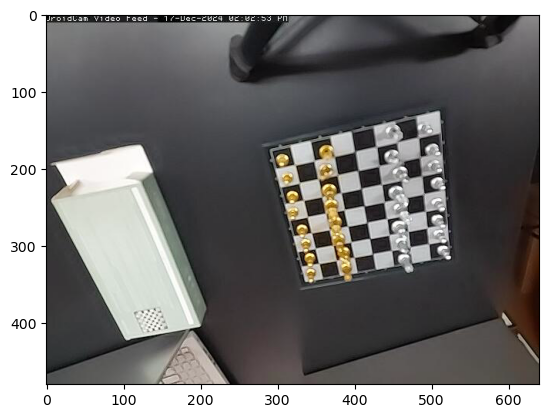

In [76]:
# src_image_path = "data/chessboard_3.jpeg"
# src_image = cv2.imread(src_image_path)

r, src_image = cv2.VideoCapture("http://192.168.0.101:4747/video").read()

# convert to RGB (otherwise when you display this image the colors will look incorrect)
src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
# convert to grayscale before attempting corner detection
src_gray = cv2.cvtColor(src_image, cv2.COLOR_RGB2GRAY)

plt.imshow(src_image)
plt.show()

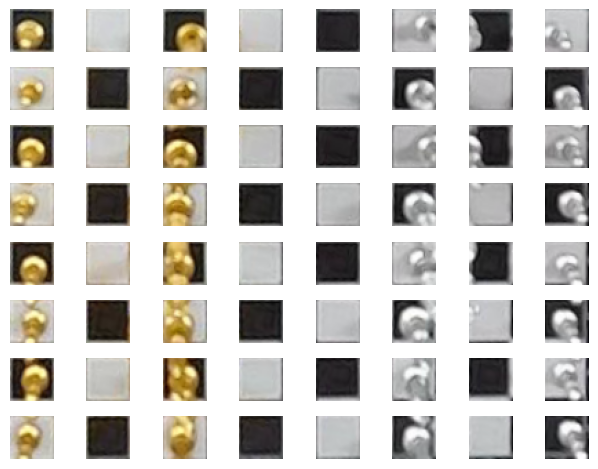

In [77]:
patches = get_board_patches(src_image)

for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, 8 * i + j + 1)
        plt.imshow(patches[i, j])
        plt.axis("off")

plt.tight_layout()
plt.show()

In [78]:
label = np.zeros((8, 8))
label[:, [0, 0+2]] = -1
label[:, [-1, -1-2]] = 1

label

array([[-1.,  0., -1.,  0.,  0.,  1.,  0.,  1.],
       [-1.,  0., -1.,  0.,  0.,  1.,  0.,  1.],
       [-1.,  0., -1.,  0.,  0.,  1.,  0.,  1.],
       [-1.,  0., -1.,  0.,  0.,  1.,  0.,  1.],
       [-1.,  0., -1.,  0.,  0.,  1.,  0.,  1.],
       [-1.,  0., -1.,  0.,  0.,  1.,  0.,  1.],
       [-1.,  0., -1.,  0.,  0.,  1.,  0.,  1.],
       [-1.,  0., -1.,  0.,  0.,  1.,  0.,  1.]])

In [79]:
data[idx] = (patches, label)
idx += 1

In [80]:
len(data)

12

[[-1.  0. -1.  0.  0.  1.  0.  1.]
 [-1.  0. -1.  0.  0.  1.  0.  1.]
 [-1.  0. -1.  0.  0.  1.  0.  1.]
 [-1.  0. -1.  0.  0.  1.  0.  1.]
 [-1.  0. -1.  0.  0.  1.  0.  1.]
 [-1.  0. -1.  0.  0.  1.  0.  1.]
 [-1.  0. -1.  0.  0.  1.  0.  1.]
 [-1.  0. -1.  0.  0.  1.  0.  1.]]


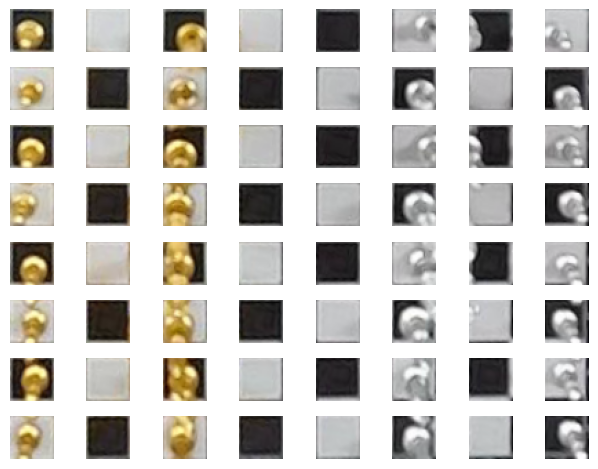

In [92]:
patches, label = data[11]
print(label)

for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, 8 * i + j + 1)
        plt.imshow(patches[i, j])
        plt.axis("off")

plt.tight_layout()
plt.show()

In [93]:
patches[0].shape

(8, 32, 32, 3)

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F

model = nn.Sequential(
    nn.Conv2d(
        in_channels=3,  # Grayscale images have 1 channel
        out_channels=32,
        kernel_size=5,
        padding=2,
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(
        in_channels=32,  # Grayscale images have 1 channel
        out_channels=64,
        kernel_size=5,
        padding=2,
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(
        in_channels=64,  # Grayscale images have 1 channel
        out_channels=128,
        kernel_size=5,
        padding=2,
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(
        in_features=4 * 4 * 128, out_features=1024
    ),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(in_features=1024, out_features=3),
)

In [95]:
x = []
y = []

for patches, labels in data.values():
    patches = einops.rearrange(patches, "NH NW H W C -> (NH NW) C H W")
    patches = torch.from_numpy(patches / 255).float()

    labels = einops.rearrange(labels, "NH NW -> (NH NW)")
    labels = torch.from_numpy(labels).long()
    labels = torch.where(labels == -1, 2, labels)
    x.append(patches)
    y.append(labels)

x = torch.cat(x)
y = torch.cat(y)

In [96]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(x, y)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [97]:
device = "cpu"
model.to(device)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [98]:
from tqdm.auto import tqdm

losses = []
model.train()
epochs = 10

for epoch in range(epochs):
    for image, label in tqdm(train_loader):
        image = image.to(device)
        label = label.to(device)

        pred = model(2 * image - 1)
        loss = criterion(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

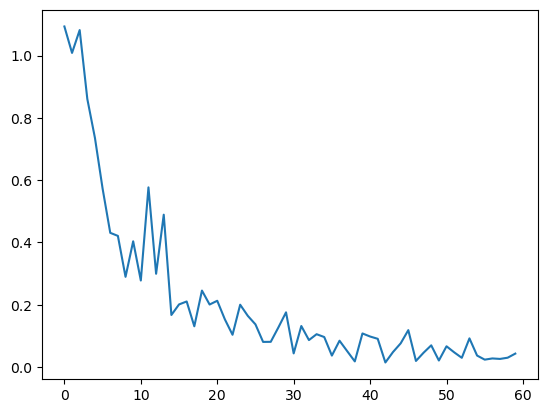

In [99]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [100]:
_ = model.eval()

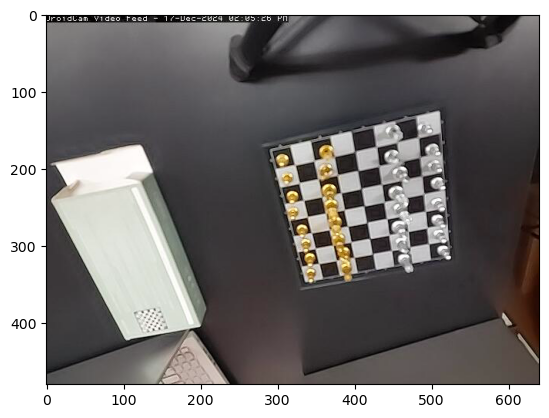

In [101]:
# src_image_path = "data/chessboard_3.jpeg"
# src_image = cv2.imread(src_image_path)

r, src_image = cv2.VideoCapture("http://192.168.0.101:4747/video").read()

# convert to RGB (otherwise when you display this image the colors will look incorrect)
src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
# convert to grayscale before attempting corner detection
src_gray = cv2.cvtColor(src_image, cv2.COLOR_RGB2GRAY)

plt.imshow(src_image)
plt.show()

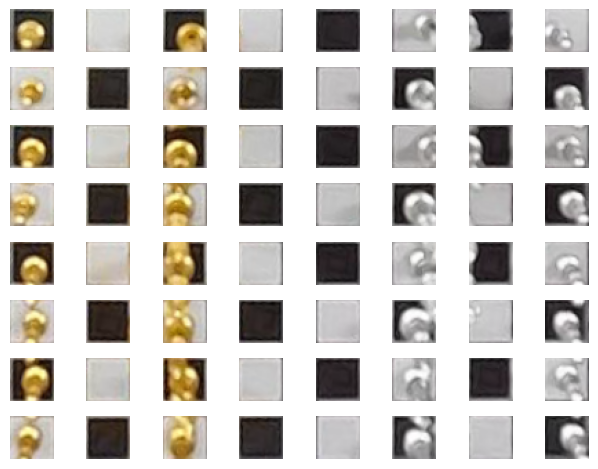

In [102]:
patches = get_board_patches(src_image)

for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, 8 * i + j + 1)
        plt.imshow(patches[i, j])
        plt.axis("off")

plt.tight_layout()
plt.show()

In [103]:
patches = einops.rearrange(patches, "NH NW H W C -> (NH NW) C H W")
patches = torch.from_numpy(patches / 255).float()

In [104]:
with torch.no_grad():
    logits = model(2 * patches - 1)

In [105]:
logits.argmax(dim=-1).reshape(8, 8)

tensor([[2, 0, 2, 0, 0, 1, 0, 1],
        [2, 0, 2, 0, 0, 1, 0, 1],
        [2, 0, 2, 0, 0, 1, 0, 1],
        [2, 0, 2, 0, 0, 1, 0, 1],
        [2, 0, 2, 0, 0, 1, 0, 1],
        [2, 0, 2, 0, 0, 1, 0, 1],
        [2, 0, 2, 0, 0, 1, 0, 1],
        [2, 0, 2, 0, 0, 1, 0, 1]])

In [106]:
torch.save(model.state_dict(), "patch_model_v2.pt")